# Class Part

In [1]:
import numpy as np
from numpy import pi,cos,sin,sqrt
from numpy.linalg import inv, matrix_rank, eig
from collections import deque
import matplotlib.pyplot as plt
import control as ct

In [71]:
class FullStateFeedback():
    def __init__(self):
        self.g=9.81
        self.fixedDeltaT=0.0001
        self.uIsNotTorque=False
    def CtrbObsv(self):
        print('Controllability: ',matrix_rank(ct.ctrb(self.A,self.B)))
        print('Observability: ',matrix_rank(ct.obsv(self.A,self.B)))
    def PolePlacement(self,poles):
        self.Kr=ct.place(self.A, self.B, poles)
        self.State()
        self.CtrbObsv()
        self.SteadyStatePerU=-inv(self.A-self.B@self.Kr)@self.B
    def Mu_d(self,setPoint):
        # set the second state to setPoint
        return setPoint/self.SteadyStatePerU[1][0]
    def SimulationSimple(self,initialState=np.zeros((3,1)),interval=0.001,timeLength=4):
        timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))
        A=self.A-self.B@self.Kr
        output=[]
        x=initialState.copy()
        for i in range(int(timeLength/interval+1)):
            x=(A*interval+np.identity(initialState.shape[0]))@x
            output.append(x.copy()[:,0])
        return timeVector,np.array(output)
    def Simulation(self,initialState=np.zeros((3,1)),setPoint=0,interval=0.001,timeLength=4,delay=0.000,QN=np.diag([0.1,0.1,0.1]),RN=0.00001,bias=0,acceleration=pi):
        # acceleration unit is rad/s^2=1/(2*pi) rev/s^2=200/(2*pi) steps/s^2 if fullstep
        QN=QN*interval**2
        timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))
        noiseQN=ct.white_noise(timeVector,QN,dt=interval).T
        noiseRN=ct.white_noise(timeVector,RN,dt=interval).T

        F=np.eye(self.A.shape[0])+self.A*interval
        B=self.B*interval
        H=self.C

        x=initialState.copy()
        u=0
        u_new=0
        xhat=initialState.copy()
        Pk=np.identity(self.A.shape[0])
        outputState=[]
        outputTorque=[]
        ud=self.Mu_d(setPoint)
        torque=0
        acc=0
        targetSpeed=0

        scaler=round(interval/self.fixedDeltaT)
        q=deque()
        for i in range(int(timeLength/interval+1)):
            torqueAvg=0
            for _ in range(scaler):
                if self.uIsNotTorque:
                    if u_new-u>acceleration*self.fixedDeltaT:
                        acc=acceleration
                        u+=acceleration*self.fixedDeltaT
                    elif u_new-u<acceleration*self.fixedDeltaT:
                        acc=-acceleration
                        u-=acceleration*self.fixedDeltaT
                    else:
                        acc=(u_new-u)/self.fixedDeltaT
                        u=u_new
                    torque=self.torqueFromAcc(x,acc)
                    torqueAvg+=torque
                    x+=self.fixedDeltaT*self.dXdt(x,acc)
                else:
                    if targetSpeed-self.currentSpeed(x)>acceleration*self.fixedDeltaT:
                        acc=acceleration
                    elif targetSpeed-self.currentSpeed(x)<-acceleration*self.fixedDeltaT:
                        acc=-acceleration
                    else:
                        acc=(targetSpeed-self.currentSpeed(x))/self.fixedDeltaT
                    torque=self.torqueFromAcc(x,acc)
                    torqueAvg+=torque
                    x+=self.fixedDeltaT*self.dXdt(x,torque)
            outputState.append(x.copy())
            outputTorque.append(torqueAvg/scaler)
            x+=np.expand_dims(noiseQN[i],1)
            y=H@x+np.reshape(noiseRN[i],(-1,1))+bias

            # kalman filter
            xcheck=F@xhat+B*u
            Pcheck=F@Pk@F.T+QN
            K=Pcheck@H.T@inv(H@Pcheck@H.T+np.identity(H.shape[0])*RN)
            xhat=xcheck+K@(y-H@xcheck)
            Pk=(np.identity(self.A.shape[0])-K@H)@Pcheck
            q.append((-self.Kr@xhat+ud)[0,0])
            if len(q)>round(delay/interval):
                u_new=q.popleft()
            acc=self.accFromU(x,u_new)
            targetSpeed=self.currentSpeed(x)+acc*interval
            if not self.uIsNotTorque:
                u=u_new
        return timeVector,np.array(outputState),np.array(outputTorque)

# region models
class InvertedPendulumOnWheel(FullStateFeedback):
    def __init__(self,m,m_w,R,L,I,I_w,Br,Bm): # define A,B,C
        super().__init__()
        self.m=m
        self.m_w=m_w
        self.R=R
        self.L=L
        self.I=I
        self.I_w=I_w
        self.Br=Br
        self.Bm=Bm
        G_1=inv(np.array([
            [I_w+(m_w+m)*R**2,m*R*L],
            [m*R*L,I+m*L**2]
        ]))
        A_lower=G_1@np.array([
            [0,-Bm-Br,Bm],
            [m*self.g*L,Bm,-Bm]
        ])
        self.A=np.vstack((np.array([[0,0,1]]),A_lower))
        self.B=np.vstack((np.array([[0]]),G_1@np.array([[1],[-1]])))
        self.C=np.array([[1,0,0]])
        self.dot2state=np.array([[0,0,1],[0,0,0],[0,0,0]])
        self.acc2state=np.array([[0,0],[1,0],[0,1]])
    def State(self):
        print('theta, phidot, thetadot')
    def currentSpeed(self,x):
        theta,phidot,thetadot=x.flatten()
        return phidot-thetadot
    def torqueFromAcc(self,x,acc):
        theta,phidot,thetadot=x.flatten()
        G_1=np.array([
            [self.I+self.m*self.L**2,-self.m*self.R*self.L*cos(theta)],
            [-self.m*self.R*self.L*cos(theta),self.I_w+(self.m_w+self.m)*self.R**2]
        ])/((self.I_w+(self.m_w+self.m)*self.R**2)*(self.I+self.m*self.L**2)-(self.m*self.R*self.L*cos(theta))**2)
        H=np.array([
            [-(self.Br+self.Bm)*phidot+self.Bm*thetadot+self.m*self.R*self.L*sin(theta)*thetadot*thetadot],
            [self.Bm*phidot-self.Bm*thetadot+self.m*self.g*self.L*sin(theta)]
        ])
        return ((acc-np.array([[1,-1]])@G_1@H)/(np.array([[1,-1]])@G_1@np.array([[1],[-1]])))[0,0]
    def accFromU(self,x,tau):
        theta,phidot,thetadot=x.flatten()
        G_1=np.array([
            [self.I+self.m*self.L**2,-self.m*self.R*self.L*cos(theta)],
            [-self.m*self.R*self.L*cos(theta),self.I_w+(self.m_w+self.m)*self.R**2]
        ])/((self.I_w+(self.m_w+self.m)*self.R**2)*(self.I+self.m*self.L**2)-(self.m*self.R*self.L*cos(theta))**2)
        H=np.array([
            [-(self.Br+self.Bm)*phidot+self.Bm*thetadot+self.m*self.R*self.L*sin(theta)*thetadot*thetadot+tau],
            [self.Bm*phidot-self.Bm*thetadot+self.m*self.g*self.L*sin(theta)-tau]
        ])
        return (np.array([[1,-1]])@G_1@H)[0,0]
    def dXdt(self,x,tau):
        theta,phidot,thetadot=x.flatten()
        G_1=np.array([
            [self.I+self.m*self.L**2,-self.m*self.R*self.L*cos(theta)],
            [-self.m*self.R*self.L*cos(theta),self.I_w+(self.m_w+self.m)*self.R**2]
        ])/((self.I_w+(self.m_w+self.m)*self.R**2)*(self.I+self.m*self.L**2)-(self.m*self.R*self.L*cos(theta))**2)
        H=np.array([
            [-(self.Br+self.Bm)*phidot+self.Bm*thetadot+self.m*self.R*self.L*sin(theta)*thetadot*thetadot+tau],
            [self.Bm*phidot-self.Bm*thetadot+self.m*self.g*self.L*sin(theta)-tau]
        ])
        return self.dot2state@x+self.acc2state@G_1@H
class ReactionWheelOnInvertedPendulum(FullStateFeedback):
    def __init__(self,m,m_w,L,L_w,I,I_w,Ba,Bm): # define A,B,C
        super().__init__()
        self.m=m
        self.m_w=m_w
        self.L=L
        self.L_w=L_w
        self.I=I
        self.I_w=I_w
        self.Ba=Ba
        self.Bm=Bm
        # state = theta, phidot, thetadot
        self.A=np.array([
            [0,0,1],
            [0,-Bm/I_w,Bm/I_w],
            [(m*L+m_w*L_w)*self.g/(I+m*L**2+m_w*L_w**2),Bm/(I+m*L**2+m_w*L_w**2),(-Bm-Ba)/(I+m*L**2+m_w*L_w**2)]
        ])
        self.B=np.array([[0],[1/I_w],[-1/(I+m*L**2+m_w*L_w**2)]])
        self.C=np.array([[1,0,0]])
    def State(self):
        print('theta, phidot, thetadot')
    def currentSpeed(self,x):
        theta,phidot,thetadot=x.flatten()
        return phidot-thetadot
    def torqueFromAcc(self,x,acc):
        theta,phidot,thetadot=x.flatten()
        numerator=acc-(-self.Bm*phidot+self.Bm*thetadot)/self.I_w-(self.Bm*phidot-(self.Bm+self.Ba)*thetadot+(self.m*self.L+self.m_w*self.L_w)*self.g*sin(theta))/(self.I+self.m_w*self.L_w**2+self.m*self.L**2)
        denominator=-1/(self.I+self.m_w*self.L_w**2+self.m*self.L**2)+1/self.I_w
        return numerator/denominator
    def accFromU(self,x,tau):
        theta,phidot,thetadot=x.flatten()
        phidot2=(-self.Bm*phidot+self.Bm*thetadot+tau)/self.I_w
        thetadot2=(self.Bm*phidot-(self.Bm+self.Ba)*thetadot+(self.m*self.L+self.m_w*self.L_w)*self.g*sin(theta)-tau)/(self.I+self.m_w*self.L_w**2+self.m*self.L**2)
        return phidot2-thetadot2
    def dXdt(self,x,tau):
        theta,phidot,thetadot=x.flatten()
        phidot2=(-self.Bm*phidot+self.Bm*thetadot+tau)/self.I_w
        thetadot2=(self.Bm*phidot-(self.Bm+self.Ba)*thetadot+(self.m*self.L+self.m_w*self.L_w)*self.g*sin(theta)-tau)/(self.I+self.m_w*self.L_w**2+self.m*self.L**2)
        return np.array([[thetadot,phidot2,thetadot2]]).T
class InvertedPendulumOnCart(FullStateFeedback):
    def __init__(self,mc,m1,l1,I1,b1,R): # define A,B,C
        super().__init__()
        self.mc=mc
        self.m1=m1
        self.l1=l1
        self.I1=I1
        self.b1=b1
        self.R=R

        G_1=inv(np.array([
            [m1+mc,1/2*m1*l1],
            [1/2*m1*l1,1/4*m1*l1**2+I1]
        ]))
        A_lower=G_1@(np.array([
            [0,1/2*m1*self.g*l1],
            [0,0],
            [0,-b1]
        ]).T)
        B_lower=G_1@np.array([[1],[0]])
        # state = theta,xdot,thetadot
        self.A=np.vstack((np.array([0,0,1]),A_lower))
        self.B=np.vstack((np.array([[0]]),B_lower))
        self.C=np.array([[1,0,0]])
        self.dot2state=np.array([[0,0,1],[0,0,0],[0,0,0]])
        self.acc2state=np.array([[0,0],[1,0],[0,1]])
    def State(self):
        print('theta,xdot,thetadot')
    def currentSpeed(self,x):
        theta,xdot,thetadot=x.flatten()
        return xdot/self.R
    def torqueFromAcc(self,x,acc):
        theta,xdot,thetadot=x.flatten()
        G_1=np.array([
            [1/4*self.m1*self.l1**2+self.I1,-1/2*self.m1*self.l1*cos(theta)],
            [-1/2*self.m1*self.l1*cos(theta),self.m1+self.mc]
        ])/(1/4*self.mc*self.m1*self.l1**2+self.I1*(self.mc+self.m1))
        H=np.array([
            [1/2*self.m1*self.l1*thetadot**2*sin(theta)],
            [1/2*self.m1*self.g*self.l1*sin(theta)-self.b1*thetadot]
        ])
        return ((acc*self.R-np.array([[1,0]])@G_1@H)*self.R/(np.array([[1,0]])@G_1@np.array([[1],[0]])))[0,0]
    def accFromU(self,x,force):
        theta,xdot,thetadot=x.flatten()
        G_1=np.array([
            [1/4*self.m1*self.l1**2+self.I1,-1/2*self.m1*self.l1*cos(theta)],
            [-1/2*self.m1*self.l1*cos(theta),self.m1+self.mc]
        ])/(1/4*self.mc*self.m1*self.l1**2+self.I1*(self.mc+self.m1))
        H=np.array([
            [force+1/2*self.m1*self.l1*thetadot**2*sin(theta)],
            [1/2*self.m1*self.g*self.l1*sin(theta)-self.b1*thetadot]
        ])
        return 1/self.R*(np.array([[1,0]])@G_1@H)[0,0]
    def dXdt(self,x,tau):
        theta,xdot,thetadot=x.flatten()
        G_1=np.array([
            [1/4*self.m1*self.l1**2+self.I1,-1/2*self.m1*self.l1*cos(theta)],
            [-1/2*self.m1*self.l1*cos(theta),self.m1+self.mc]
        ])/(1/4*self.mc*self.m1*self.l1**2+self.I1*(self.mc+self.m1))
        H=np.array([
            [tau/self.R+1/2*self.m1*self.l1*thetadot**2*sin(theta)],
            [1/2*self.m1*self.g*self.l1*sin(theta)-self.b1*thetadot]
        ])
        return self.dot2state@x+self.acc2state@G_1@H
    def LQR(self,QW,RW):
        Kr, _, _ = ct.lqr(self.A,self.B,QW,RW)
        self.Kr=Kr
        print(eig(self.A-self.B@Kr)[0])
        self.State()
        self.CtrbObsv()
        self.SteadyStatePerU=np.array([[0,1,0,0,0]]).T
class DoubleInvertedPendulumOnCart(FullStateFeedback):
    def __init__(self,mc,m1,l1,I1,b1,m2,l2,I2,b2,R): # define A,B,C
        super().__init__()
        self.mc=mc
        self.m1=m1
        self.l1=l1
        self.I1=I1
        self.b1=b1
        self.m2=m2
        self.l2=l2
        self.I2=I2
        self.b2=b2
        self.R=R

        G_00=mc+m1+m2
        G_01=(1/2*m1+m2)*l1
        G_02=1/2*m2*l2
        G_11=(1/4*m1+m2)*l1**2+I1
        G_12=1/2*m2*l1*l2
        G_22=1/4*m2*l2**2+I2
        G_1=inv(np.array([
            [G_00,G_01,G_02],
            [G_01,G_11,G_12],
            [G_02,G_12,G_22],
            
        ]))
        A_lower=G_1@(np.array([
            [0,(1/2*m1+m2)*self.g*l1,0],
            [0,0,1/2*m2*self.g*l2],
            [0,0,0],
            [0,-b1,b2],
            [0,0,-b2]
        ]).T)
        B_lower=G_1@np.array([[1],[0],[0]])
        # state = theta,phi,xdot,thetadot,phidot
        self.A=np.vstack((np.hstack((np.zeros((2,3)),np.identity(2))),A_lower))
        self.B=np.vstack((np.array([[0],[0]]),B_lower))
        self.C=np.array([[1,0,0,0,0],[-1,1,0,0,0]])
        self.dot2state=np.array([[0,0,0,1,0],[0,0,0,0,1],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
        self.acc2state=np.array([[0,0,0],[0,0,0],[1,0,0],[0,1,0],[0,0,1]])
    def State(self):
        print('theta,phi,xdot,thetadot,phidot')
    def currentSpeed(self,x):
        theta,phi,xdot,thetadot,phidot=x.flatten()
        return xdot/self.R
    def torqueFromAcc(self,x,acc):
        theta,phi,xdot,thetadot,phidot=x.flatten()
        G_00=self.mc+self.m1+self.m2
        G_01=(1/2*self.m1+self.m2)*self.l1*cos(theta)
        G_02=1/2*self.m2*self.l2*cos(phi)
        G_11=(1/4*self.m1+self.m2)*self.l1**2+self.I1
        G_12=1/2*self.m2*self.l1*self.l2*cos(phi-theta)
        G_22=1/4*self.m2*self.l2**2+self.I2
        G_1=inv(np.array([
            [G_00,G_01,G_02],
            [G_01,G_11,G_12],
            [G_02,G_12,G_22],
        ]))
        H=np.array([
            [(1/2*self.m1+self.m2)*self.l1*sin(theta)*thetadot**2+1/2*self.m2*self.l2*sin(phi)*phidot**2],
            [1/2*self.m2*self.l1*self.l2*sin(phi-theta)*phidot**2+(1/2*self.m1+self.m2)*self.g*self.l1*sin(theta)-self.b1*thetadot],
            [-1/2*self.m2*self.l1*self.l2*sin(phi-theta)*thetadot**2+1/2*self.m2*self.g*self.l2*sin(phi)-self.b2*(phidot-thetadot)]
        ])
        return ((acc*self.R-np.array([[1,0,0]])@G_1@H)*self.R/(np.array([[1,0,0]])@G_1@np.array([[1],[0],[0]])))[0,0]
    def accFromU(self,x,force):
        theta,phi,xdot,thetadot,phidot=x.flatten()
        G_00=self.mc+self.m1+self.m2
        G_01=(1/2*self.m1+self.m2)*self.l1*cos(theta)
        G_02=1/2*self.m2*self.l2*cos(phi)
        G_11=(1/4*self.m1+self.m2)*self.l1**2+self.I1
        G_12=1/2*self.m2*self.l1*self.l2*cos(phi-theta)
        G_22=1/4*self.m2*self.l2**2+self.I2
        G_1=inv(np.array([
            [G_00,G_01,G_02],
            [G_01,G_11,G_12],
            [G_02,G_12,G_22],
        ]))
        H=np.array([
            [force+(1/2*self.m1+self.m2)*self.l1*sin(theta)*thetadot**2+1/2*self.m2*self.l2*sin(phi)*phidot**2],
            [1/2*self.m2*self.l1*self.l2*sin(phi-theta)*phidot**2+(1/2*self.m1+self.m2)*self.g*self.l1*sin(theta)-self.b1*thetadot],
            [-1/2*self.m2*self.l1*self.l2*sin(phi-theta)*thetadot**2+1/2*self.m2*self.g*self.l2*sin(phi)-self.b2*(phidot-thetadot)]
        ])
        return 1/self.R*(np.array([[1,0,0]])@G_1@H)[0,0]
    def dXdt(self,x,tau):
        theta,phi,xdot,thetadot,phidot=x.flatten()
        G_00=self.mc+self.m1+self.m2
        G_01=(1/2*self.m1+self.m2)*self.l1*cos(theta)
        G_02=1/2*self.m2*self.l2*cos(phi)
        G_11=(1/4*self.m1+self.m2)*self.l1**2+self.I1
        G_12=1/2*self.m2*self.l1*self.l2*cos(phi-theta)
        G_22=1/4*self.m2*self.l2**2+self.I2
        G_1=inv(np.array([
            [G_00,G_01,G_02],
            [G_01,G_11,G_12],
            [G_02,G_12,G_22],
        ]))
        H=np.array([
            [tau/self.R+(1/2*self.m1+self.m2)*self.l1*sin(theta)*thetadot**2+1/2*self.m2*self.l2*sin(phi)*phidot**2],
            [1/2*self.m2*self.l1*self.l2*sin(phi-theta)*phidot**2+(1/2*self.m1+self.m2)*self.g*self.l1*sin(theta)-self.b1*thetadot],
            [-1/2*self.m2*self.l1*self.l2*sin(phi-theta)*thetadot**2+1/2*self.m2*self.g*self.l2*sin(phi)-self.b2*(phidot-thetadot)]
        ])
        return self.dot2state@x+self.acc2state@G_1@H
    def LQR(self,QW,RW):
        Kr, _, _ = ct.lqr(self.A,self.B,QW,RW)
        self.Kr=Kr
        print(eig(self.A-self.B@Kr)[0])
        self.State()
        self.CtrbObsv()
        self.SteadyStatePerU=np.array([[0,1,0,0,0]]).T
    def SetKr(self,Kr):
        self.Kr=Kr
        print(eig(self.A-self.B@Kr)[0])
        self.State()
        self.CtrbObsv()
        self.SteadyStatePerU=np.array([[0,1,0,0,0]]).T
class BallOnBeam(FullStateFeedback):
    def __init__(self,m,r,d,I,b,ratio): # define A,B,C
        super().__init__()
        self.m=m
        self.r=r
        self.d=d
        self.I=I
        self.b=b
        self.ratio=ratio

        # state = theta,R,Rdot        
        self.A=np.array([[0,0,0],[0,0,1],[-ratio*self.g,0,-ratio*b/m]])
        self.B=np.array([[1],[0],[0]])
        self.C=np.array([[1,0,0],[0,1,0]])

        self.thetadot=0
        self.uIsNotTorque=True
    def State(self):
        print('theta,R,Rdot')
    def currentSpeed(self,x):
        return 0
    def torqueFromAcc(self,x,thetadot2):
        theta,R,Rdot=x.flatten()
        det=-7/5*R**2-2/5*self.d**2-2/5*self.r**2+4/5*self.d*self.r-7/5*self.I/self.m
        tau=self.m*(2*R*Rdot*self.thetadot+self.g*R*cos(theta)-self.g*self.d*sin(theta))-5/7*self.m*(thetadot2*det-(self.d+2/5*self.r)*(-R*self.thetadot**2+self.b/self.m*Rdot+self.g*sin(theta)))
        return tau
    def accFromU(self,x,thetadot):
        return 0
    def dXdt(self,x,thetadot2):
        theta,R,Rdot=x.flatten()
        det=-7/5*R**2-2/5*self.d**2-2/5*self.r**2+4/5*self.d*self.r-7/5*self.I/self.m
        tau=self.m*(2*R*Rdot*self.thetadot+self.g*R*cos(theta)-self.g*self.d*sin(theta))-5/7*self.m*(thetadot2*det-(self.d+2/5*self.r)*(-R*self.thetadot**2+self.b/self.m*Rdot+self.g*sin(theta)))
        Rdot2=((self.d+2/5*self.r)*(2*R*Rdot*self.thetadot+self.g*R*cos(theta)-self.g*self.d*sin(theta)-1/self.m*tau)+(R**2+self.d**2+self.I/self.m+2/5*self.r**2)*(-R*self.thetadot**2+self.b/self.m*Rdot+self.g*sin(theta)))/det

        self.thetadot+=self.fixedDeltaT*thetadot2
        return np.array([[self.thetadot,Rdot,Rdot2]]).T
class ControlMomentGyroscope(FullStateFeedback):
    def __init__(self,r2,r1,h,m,mb,r,rb,Bw,psidot): # define A,B,C
        super().__init__()
        self.Ixy=1/12*m*(3*(r2**2+r1**2)+h**2)
        self.Iz=1/2*m*(r2**2+r1**2)
        self.Ic=self.Iz-self.Ixy
        self.Ib=2*m*r**2+mb*rb**2
        self.p=self.g*(2*m*r+mb*rb)
        self.Bw=Bw
        self.psidot=psidot

        # state = theta,phi,thetadot
        self.A=np.array([
            [0,0,1],
            [0,0,0],
            [self.p/(2*self.Ixy+self.Ib),0,0],
        ])
        self.B=np.array([[0],[1],[-2*self.Iz*psidot/(2*self.Ixy+self.Ib)]])
        self.C=np.array([[1,0,0],[0,1,0]])

        self.phidot=0
        self.uIsNotTorque=True
    def State(self):
        print('theta,phi,thetadot')
    def currentSpeed(self,x):
        return 0
    def torqueFromAcc(self,x,phidot2):
        theta,phi,thetadot=x.flatten()
        return 2*self.Ixy*phidot2-self.Ic*thetadot**2*sin(2*phi)-2*self.Iz*self.psidot*thetadot*cos(phi)+self.Bw*self.phidot
    def accFromU(self,x,phidot):
        return 0
    def dXdt(self,x,phidot2):
        theta,phi,thetadot=x.flatten()
        thetadot2=(-2*self.Ic*thetadot*self.phidot*sin(2*phi)-2*self.Iz*self.psidot*self.phidot*cos(phi)+self.p*sin(theta))/(2*self.Ixy*cos(phi)**2+2*self.Iz*sin(phi)**2+self.Ib)
        
        self.phidot+=self.fixedDeltaT*phidot2
        return np.array([[thetadot,self.phidot,thetadot2]]).T
# endregion

In [3]:
def secondOrderPoles(overshoot,risingTime):
    dampingRatio=sqrt(np.log(overshoot)**2/(pi**2+np.log(overshoot)**2))
    naturalFrequency=(1-0.4167*dampingRatio+2.917*dampingRatio**2)/risingTime
    return np.array([
        -dampingRatio*naturalFrequency+naturalFrequency*sqrt(1-dampingRatio**2)*1j,
        -dampingRatio*naturalFrequency-naturalFrequency*sqrt(1-dampingRatio**2)*1j,
        ])
secondOrderPoles(0.01,0.5)

array([-4.37226884+2.98271011j, -4.37226884-2.98271011j])

# Examples

## InvertedPendulumOnWheel

theta, phidot, thetadot
Controllability:  3
Observability:  3


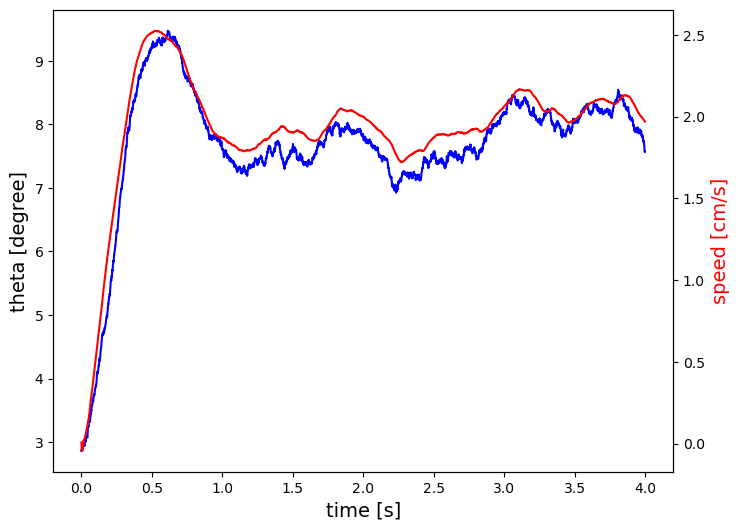

In [48]:
R=25*10**-3
testObj=InvertedPendulumOnWheel(
    m=131.44*10**-3, # kg
    m_w=11.78*10**-3, # kg
    R=R, # m
    L=44.97*10**-3,# m
    I=409131.25*10**-9, #kg m^2
    I_w=3681.55*10**-9, #kg m^2
    Br=0.01,
    Bm=0.01,
)
# state = theta, phidot, thetadot
testObj.PolePlacement(np.array([-6.9,-7.1,-30]))
timeVector,outputState,torqueValue=testObj.Simulation(initialState=np.array([[0.05,0,0]]).T,setPoint=2/R/100,delay=0.005,acceleration=10)
thetaValue=outputState[:,0]
phidotValue=outputState[:,1]

plt.figure(figsize=(8,6))
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('theta [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,phidotValue*R*100, 'r')
rightax.set_ylabel('speed [cm/s]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## ReactionWheelOnInvertedPendulum

theta, phidot, thetadot
Controllability:  3
Observability:  3


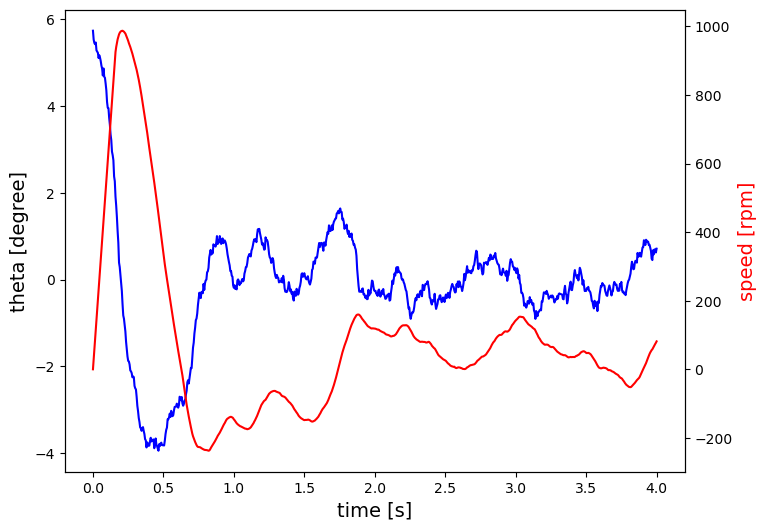

In [53]:
testObj=ReactionWheelOnInvertedPendulum(
    m=114.34*10**-3, # kg
    m_w=28.88*10**-3, # kg
    L=60.27*10**-3, # m
    L_w=90*10**-3, # m
    I=541060.43*10**-9, # kg m^2
    I_w=29865.94*10**-9, # kg m^2
    Ba=0.01,
    Bm=0.01,
)
# state = theta, phidot, thetadot
testObj.PolePlacement(np.array([-4.37226884+2.98271011j, -4.37226884-2.98271011j,-10]))
timeVector,outputState,torqueValue=testObj.Simulation(interval=0.005,initialState=np.array([[0.1,0,0]]).T,delay=0.001,acceleration=600)
thetaValue=outputState[:,0]
phidotValue=outputState[:,1]

plt.figure(figsize=(8,6))
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('theta [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,phidotValue*30/pi, 'r')
rightax.set_ylabel('speed [rpm]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## InvertedPendulumOnCart

In [91]:
m1=50*10**-3
l1=0.3
I1=1/12*m1*l1
testObj=InvertedPendulumOnCart(
    mc=10*10**-3, # kg
    m1=m1, # kg
    l1=l1, # m
    I1=I1,
    b1=0.01,
    R=0.03,
)
# state = theta,xdot,thetadot
# testObj.LQR(QW=np.diag([1,10,10]),RW=1)
testObj.PolePlacement(np.array([-5+1.j, -5-1.j,-10]))

theta,xdot,thetadot
Controllability:  3
Observability:  3


[[-2.44398804 -0.30479103 -0.24651716]]


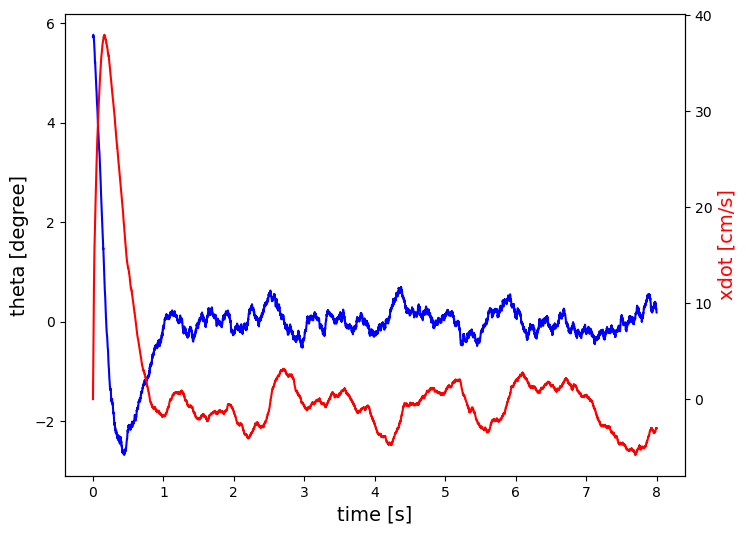

In [93]:
timeVector,outputState,torqueValue=testObj.Simulation(timeLength=8,initialState=np.array([[0.1,0,0]]).T,delay=0.000,acceleration=1000)
thetaValue=outputState[:,0]
xdotValue=outputState[:,1]
print(testObj.Kr)

interval=0.001
x=0
xValue=[]
for i in range(xdotValue.shape[0]):
    x+=xdotValue[i,0]*interval
    xValue.append(x)
xValue=np.array(xValue)

plt.figure(figsize=(8,6))
plt.xlabel('time [s]', fontsize=14)
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.ylabel('theta [degree]',fontsize=14)
# plt.plot(timeVector,xValue*100, 'b')
# plt.ylabel('x [cm]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,xdotValue*100, 'r')
rightax.set_ylabel('xdot [cm/s]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## DoubleInvertedPendulumOnCart

In [7]:
m1=10*10**-3
l1=0.2
I1=1/12*m1*l1
m2=10*10**-3
l2=0.2
I2=1/12*m2*l2
# pendulum 2 has no effect
testObj=DoubleInvertedPendulumOnCart(
    mc=30*10**-3, # kg
    m1=m1, # kg
    l1=l1, # m
    I1=I1,
    b1=0.01,
    m2=0, # kg
    l2=l2, # m
    I2=I2,
    b2=0.00,
    R=0.03,
)
# state = theta,phi,xdot,thetadot,phidot
testObj.SetKr(np.array([[-0.88041393,0,-0.02463473,0.30643074,0]]))

[-5.00000191+0.j         -1.99999898+1.00000145j -1.99999898-1.00000145j
  0.        +0.j          0.        +0.j        ]
theta,phi,xdot,thetadot,phidot
Controllability:  3
Observability:  4


In [ ]:
m1=10*10**-3
l1=0.2
I1=1/12*m1*l1
m2=10*10**-3
l2=0.2
I2=1/12*m2*l2
# pendulum 1 has no effect
testObj=DoubleInvertedPendulumOnCart(
    mc=30*10**-3, # kg
    m1=0, # kg
    l1=0, # m
    I1=I1,
    b1=0.01,
    m2=m2, # kg
    l2=l2, # m
    I2=I2,
    b2=0.01,
    R=0.03,
)
# state = theta,phi,xdot,thetadot,phidot
testObj.SetKr(np.array([[0,-0.88041393,-0.02463473,0,0.30643074]]))

[ -5.00000191+0.j          -1.99999898+1.00000145j
  -1.99999898-1.00000145j   0.        +0.j
 -60.        +0.j        ]
theta,phi,xdot,thetadot,phidot
Controllability:  3
Observability:  4


In [103]:
m1=10*10**-3
l1=0.2
I1=1/12*m1*l1
m2=10*10**-3
l2=0.2
I2=1/12*m2*l2

testObj=DoubleInvertedPendulumOnCart(
    mc=30*10**-3, # kg
    m1=m1, # kg
    l1=l1, # m
    I1=I1,
    b1=0.01,
    m2=m2, # kg
    l2=l2, # m
    I2=I2,
    b2=0.01,
    R=0.03,
)
# state = theta,phi,xdot,thetadot,phidot
testObj.LQR(QW=np.diag([10,100,10,1,1]),RW=10)

[-69.16394956 -55.97379997  -9.24705389  -1.5660298   -1.02540479]
theta,phi,xdot,thetadot,phidot
Controllability:  5
Observability:  5


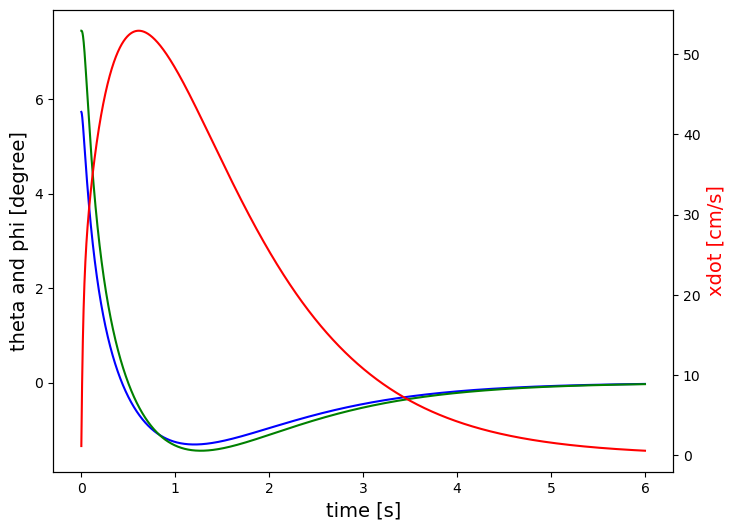

In [81]:
# state = theta,phi,xdot,thetadot,phidot
timeVector,outputState=testObj.SimulationSimple(timeLength=6,initialState=np.array([[0.1,0.13,0,0,0]]).T)
thetaValue=outputState[:,0]
phiValue=outputState[:,1]
xdotValue=outputState[:,2]
thetadotValue=outputState[:,3]
phidotValue=outputState[:,4]

plt.figure(figsize=(8,6))
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,phiValue*180/pi, 'g')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('theta and phi [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,xdotValue*100, 'r')
rightax.set_ylabel('xdot [cm/s]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

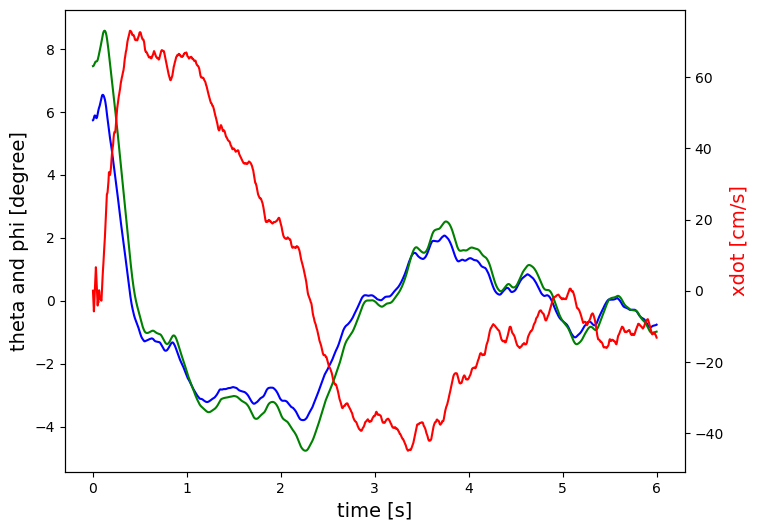

In [105]:
timeVector,outputState,torqueValue=testObj.Simulation(timeLength=6,initialState=np.array([[0.1,0.13,0,0,0]]).T,QN=np.diag([0,0,0,0,0.00]),RN=np.diag([0.001,0.001]),acceleration=200)
thetaValue=outputState[:,0]
phiValue=outputState[:,1]
xdotValue=outputState[:,2]
thetadotValue=outputState[:,3]
phidotValue=outputState[:,4]

plt.figure(figsize=(8,6))
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,phiValue*180/pi, 'g')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('theta and phi [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,xdotValue*100, 'r')
rightax.set_ylabel('xdot [cm/s]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## BallOnBeam

theta,R,Rdot
Controllability:  3
Observability:  3


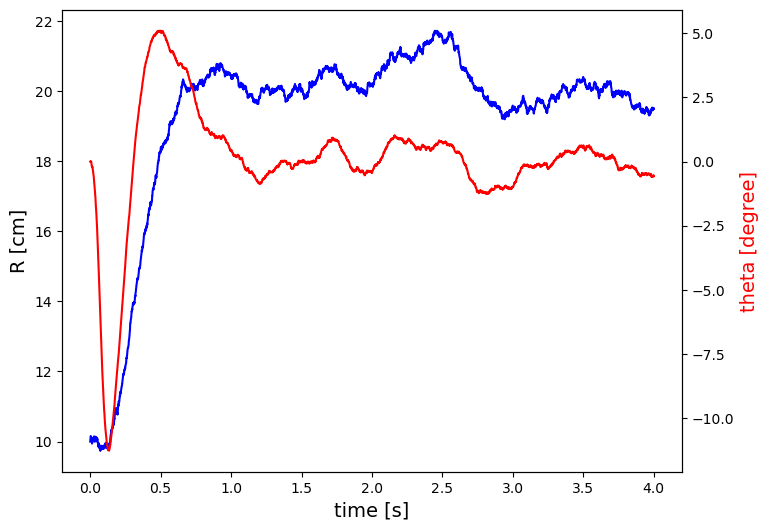

In [43]:
testObj=BallOnBeam(
    m=30*10**-3, # kg
    r=0.01, # m
    d=0.03, # m
    I=0.001*3*10**-4, # kg m^2
    b=0.01, # kg/s=N/m*s
    ratio=5/7, # option: 1, 5/7, 25/49
)
# state = theta, R, Rdot
testObj.PolePlacement(np.array([-4.37226884+2.98271011j, -4.37226884-2.98271011j,-10]))
timeVector,outputState,torqueValue=testObj.Simulation(interval=0.001,initialState=np.array([[0,0.1,0]]).T,setPoint=0.2,acceleration=50)
thetaValue=outputState[:,0]
RValue=outputState[:,1]

plt.figure(figsize=(8,6))
plt.plot(timeVector,RValue*100, 'b')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('R [cm]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,thetaValue*180/pi, 'r')
rightax.set_ylabel('theta [degree]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## ControlMomentGyroscope

theta,phi,thetadot
Controllability:  3
Observability:  3


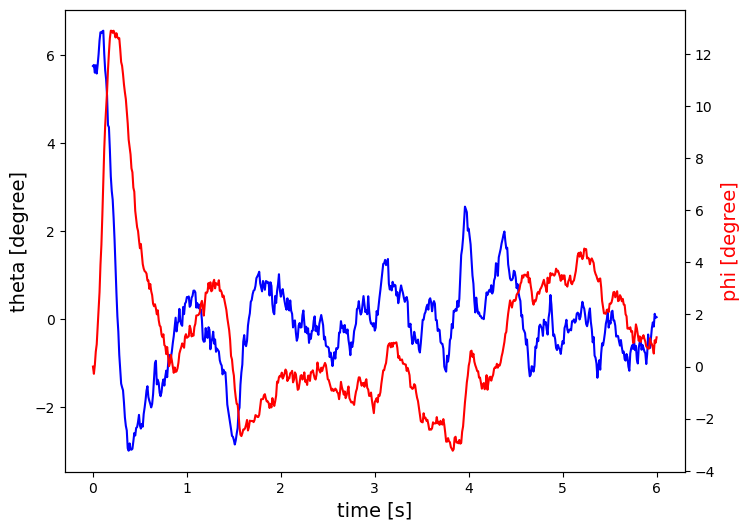

In [44]:
r2=5*10**-2
r1=r2-1*10**-2
h=1*10**-2
m=pi*(r2**2-r1**2)*h*2.7*1000
mb=m/10
testObj=ControlMomentGyroscope(
    r2=r2,
    r1=r1,
    h=h,
    m=m,
    mb=mb,
    r=10*10**-2,
    rb=5*10**-2,
    Bw=0.01,
    psidot=600*pi/30,
)
# state = theta,phi,thetadot
testObj.PolePlacement(np.array([-4.37226884+2.98271011j, -4.37226884-2.98271011j,-10]))
timeVector,outputState,torqueValue=testObj.Simulation(interval=0.01,initialState=np.array([[0.1,0,0]]).T,timeLength=6,delay=0.002,bias=np.array([[0.000],[0]]),acceleration=20)
thetaValue=outputState[:,0]
phiValue=outputState[:,1]

plt.figure(figsize=(8,6))
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('theta [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,phiValue*180/pi, 'r')
rightax.set_ylabel('phi [degree]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

# Gyroscope

In [2]:
r2=5*10**-2
r1=r2-1*10**-2
h=1*10**-2
m=pi*(r2**2-r1**2)*h*2.7*1000
R=10*10**-2
p=9.81*m*R
Ixy=1/12*m*(3*(r2**2+r1**2)+h**2)+m*R**2
Iz=1/2*m*(r2**2+r1**2)
Ic=Iz-Ixy

In [8]:
interval=0.001
scaler=interval/0.0001
timeLength=3
timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))

# q= Rz(phi) Rx(theta) Rz(psi)
theta,thetadot,phi,phidot=pi/8,0,0,-3
thetaTemp=theta
psidot=100
# psidot=(p-Ic*phidot**2*cos(theta))/(Iz*phidot) # this will make thetadot=0
# print(psidot)

E=Ixy/2*(phidot**2*sin(theta)**2+thetadot**2)+Iz/2*(phidot*cos(theta)+psidot)**2+p*cos(theta)
p_phi=(Ixy*sin(theta)**2+Iz*cos(theta)**2)*phidot+Iz*psidot*cos(theta)
p_psi=Iz*(phidot*cos(theta)+psidot)
E2=E-p_psi**2/2/Iz
print('p_phi: ',p_phi)
print('p_psi: ',p_psi)
print('E2: ',E2)

thetaValue=[]
thetadotValue=[]
phiValue=[]
phidotValue=[]
psidotValue=[]
error=[]

for i in range(int(timeLength/interval+1)):
    # plant
    for j in range(int(scaler)):
        deltatheta=0.0001*thetadot
        deltathetadot=0.0001*(1/2*phidot**2*sin(2*theta)+Iz/2/Ixy*(-phidot**2*sin(2*theta)-2*psidot*phidot*sin(theta))+1/Ixy*p*sin(theta))
        theta+=deltatheta
        thetadot+=deltathetadot
        # make sure E2 is const.
        if j==(int(scaler))-1:
            newE2=Ixy/2*thetadot**2+(p_phi-p_psi*cos(theta))**2/(2*Ixy*sin(theta)**2)+p*cos(theta)
            thetadot*=sqrt(E2/newE2)
            E3=E2-Ixy/2*thetadot**2
            y=0
            while True:
                slope=(p_phi-p_psi*cos(theta))*(p_psi-p_phi*cos(theta))/(Ixy*sin(theta)**3)-p*sin(theta)
                theta-=y/slope
                y=(p_phi-p_psi*cos(theta))**2/(2*Ixy*sin(theta)**2)+p*cos(theta)-E3
                if (1-0.01)<((y+E3+Ixy/2*thetadot**2)/E2)<(1+0.01):
                    break
        phidot=(p_phi-p_psi*cos(theta))/(Ixy*sin(theta)**2)
        phi+=phidot*0.0001
        psidot=p_psi/Iz-(p_phi-p_psi*cos(theta))*cos(theta)/(Ixy*sin(theta)**2)
    thetaValue.append(theta)
    thetadotValue.append(thetadot)
    phiValue.append(phi)
    phidotValue.append(phidot)
    psidotValue.append(psidot)

thetaValue=np.array(thetaValue)
thetadotValue=np.array(thetadotValue)
phiValue=np.array(phiValue)
phidotValue=np.array(phidotValue)
psidotValue=np.array(psidotValue)

p_phi:  0.013687778459032738
p_psi:  0.015216086692536082
E2:  0.06974462787832336


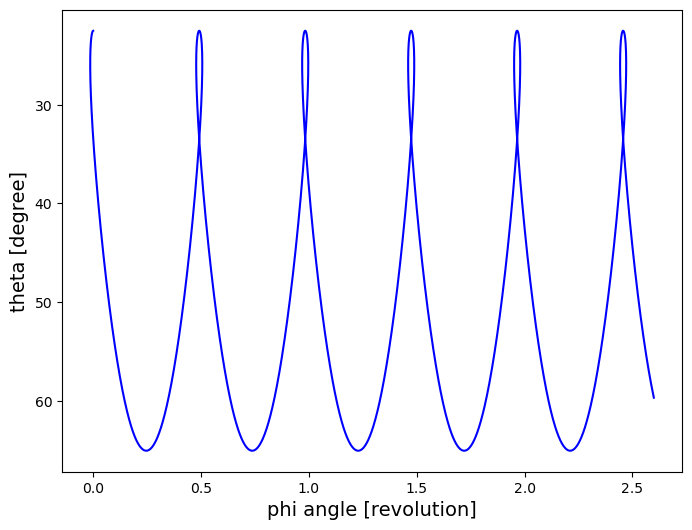

In [9]:
plt.figure(figsize=(8,6))
plt.plot(phiValue/2/pi,(thetaValue*180/pi)%360, 'b')
plt.ylabel('theta [degree]',fontsize=14)
plt.xlabel('phi angle [revolution]', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

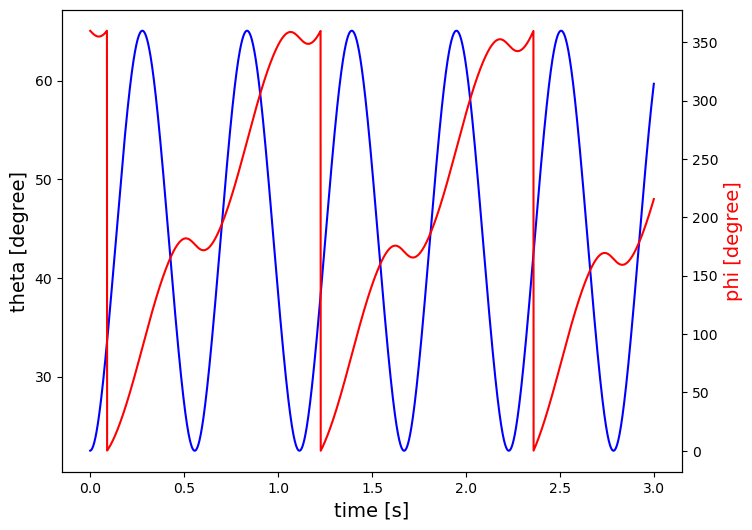

In [10]:
plt.figure(figsize=(8,6))
plt.plot(timeVector,(thetaValue*180/pi)%360, 'b')
plt.ylabel('theta [degree]',fontsize=14)
# plt.plot(timeVector,thetadotValue, 'b')
# plt.ylabel('thetadot [rad/s]',fontsize=14)
plt.xlabel('time [s]', fontsize=14)
rightax=plt.twinx()
plt.plot(timeVector,(phiValue*180/pi)%360, 'r')
plt.ylabel('phi [degree]',fontsize=14)
# rightax.plot(timeVector,phidotValue, 'r')
# rightax.set_ylabel('phidot [rad/s]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()